In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})  # Adjust 12 to your preferred size
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
import torch.nn as nn
import pandas as pd

from data import parallel_line, orthogonal, triangle, lines_3D, real_data_loader, add_noise_data
from models import Autoencoder, CNN_Autoencoder
from train import train_AE, train_TAE
from batch import train_batch_TAE, train_batch_AE
from batch import train_batch_STAE, SharedOne, SharedTwo, SharedThree
import math
device = 'cpu' 

/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <657200D0-E150-3B86-A0C5-7FD4B7F7C533> /Users/omardebouni/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


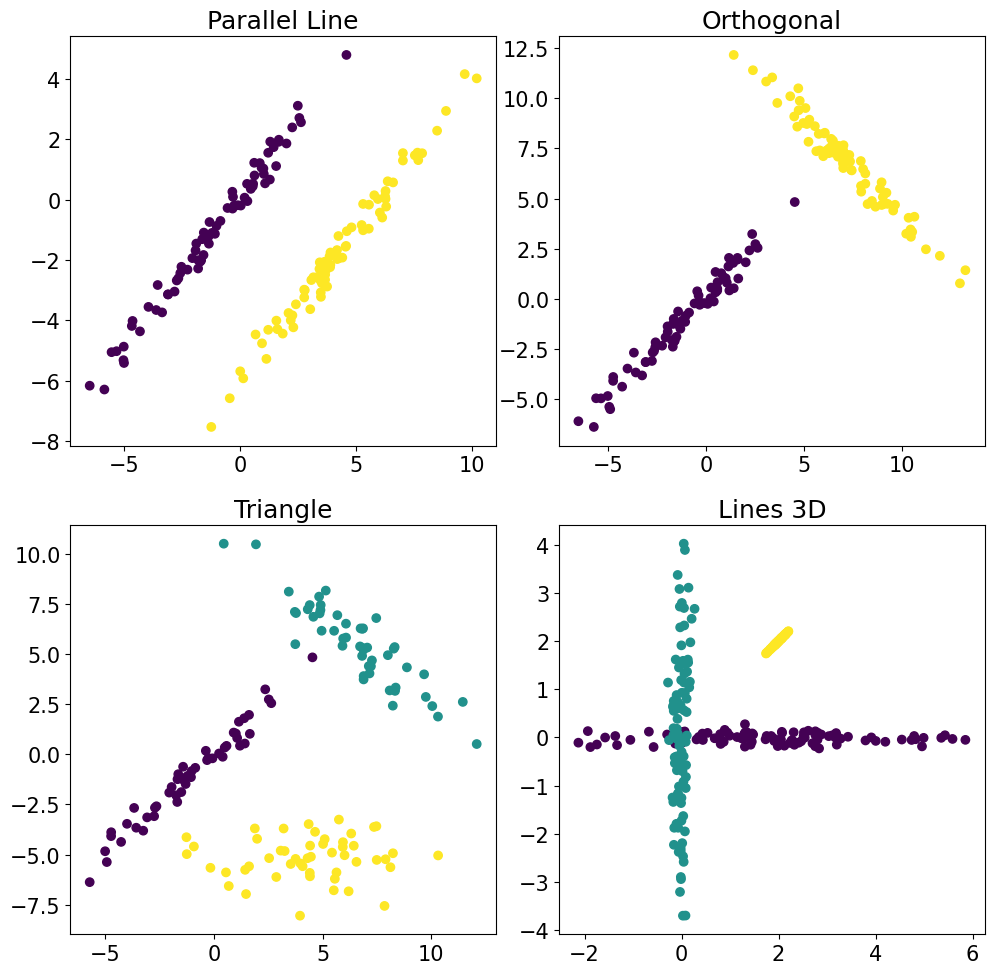

In [2]:
datasets = [parallel_line(noise=0), orthogonal(noise=0), triangle(noise=0), lines_3D(noise=0)]
dataset_titles = ['Parallel Line', 'Orthogonal', 'Triangle', 'Lines 3D']
# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# Flatten the array of axes for easy iteration
axs = axs.flatten()
# Iterate over the datasets, titles, and axes
for set, title, ax in zip(datasets, dataset_titles, axs):
    X, Y, X_noise, n_clusters = set   
    # Define colors based on labels
    color = ['red' if l == 0 else 'blue' if l == 1 else 'green' for l in Y.cpu().detach().numpy()]
    # Create a scatter plot on the specified axis
    ax.scatter(X[:,0], X[:,1], c=Y.cpu().detach().numpy(), cmap='viridis')
    ax.set_title(title)
# Show the plot
plt.tight_layout()
plt.show()

### 3.1 Reproduction of TAE

In [3]:
# kmeans_ari, ae_ari, tae_ari gives the ari of respective algorithms
# hyperparameters: repetition, epochs, lr, reg,  
repetition = 5

np.random.seed(24)
ae_ari = []
tae_ari = []
kmeans_ari = []
shared_ari = []

plot_kmeans = []
plot_ae = []
plot_tae = []
plot_stae = []

X_plot = []
arcs_plot = []

for (data_generation, lr,epochs) in [
                            (parallel_line(noise=0), 0.01, 150), 
                            (orthogonal(noise=0), 0.01, 100), 
                            (triangle(noise=0),0.1, 150), 
                            (lines_3D(noise=0),0.1, 150)
                             ]:
    print("shape of dataset: ", data_generation[0].shape)
    
    ae = []
    tae = []
    kmeans_ = []
    shared = []
    
    for rep in range(repetition):
        print(rep)
        X,Y,X_noise,n_clusters = data_generation
        x_idx = torch.tensor(np.arange(X.shape[0]))
        shuffle_idx = torch.randperm(x_idx.shape[0])
        x_idx = x_idx[shuffle_idx]
        X = X[x_idx].float().to(device)
        Y = Y[x_idx].float().to(device)

        X_plot.append(X)
        
        # k means
        k = KMeans(n_clusters=n_clusters, random_state=rep,n_init=10).fit(X.cpu())
        k_ari = adjusted_rand_score(k.labels_, Y.cpu())
        kmeans_.append(k_ari)
        
        # Standard AE
        # print("standard AE:")
        net = Autoencoder(in_feature=X.shape[1],embed=1).to(device)
        ae_l = train_AE(net,X.clone(),Y.clone(), lr=0.01,epochs=epochs)
        X_embed = net.enc1(X).cpu().detach().numpy()
        kmeans = KMeans(n_clusters=n_clusters, random_state=0,n_init=10).fit(X_embed)
        AE_clust_assign = kmeans.labels_
        ari = adjusted_rand_score(AE_clust_assign, Y.cpu())
        ae.append(ari)
        
        # Tensorized AE
        # print("Tensorized AE:")
        _, tae_l, TAE_clust_assign, _, _, _ = train_TAE(X.clone(),Y.clone(), n_clusters=n_clusters, lr=lr, reg=0.1,  shared=(False, 1, 1), epochs=epochs)
        ari = adjusted_rand_score(torch.argmax(TAE_clust_assign,axis=0).cpu().detach().numpy(), Y.cpu())
        tae.append(ari)
        
        # Shared TAE
        # print("Shared TAE:")
        _, shared_l, SHARED_clust_assign, _, _, _ = train_TAE(X.clone(),Y.clone(), n_clusters=n_clusters, lr=lr, reg=0.1, epochs=epochs,shared=(True, 2, 1))
        ari = adjusted_rand_score(torch.argmax(SHARED_clust_assign,axis=0).cpu().detach().numpy(), Y.cpu())
        shared.append(ari)
    
    arcs = [
        KMeans(n_clusters=n_clusters, random_state=24,n_init=10).fit_predict(X),
        KMeans(n_clusters=n_clusters, random_state=24,n_init=10).fit_predict(X_embed),
        torch.argmax(TAE_clust_assign,axis=0).cpu().detach().numpy(),
        torch.argmax(SHARED_clust_assign,axis=0).cpu().detach().numpy()
        ]
    arcs_plot.append(arcs)          
    kmeans_ari.append(kmeans_)   
    ae_ari.append(ae)
    tae_ari.append(tae)
    shared_ari.append(shared)

shape of dataset:  torch.Size([150, 5])
0
10
20
epoch  149  loss  0.2596117812131221
partly shared architecture
28
epoch  149  loss  0.11671391984292616
1
10
20
epoch  149  loss  0.25511426583708574
partly shared architecture
28
epoch  149  loss  0.11582252794799085
2
10
20
epoch  149  loss  0.6039420442779859
partly shared architecture
28
epoch  149  loss  0.294644578465571
3
10
20
epoch  149  loss  0.34125751021162914
partly shared architecture
28
epoch  149  loss  0.6013031362493833
4
10
20
epoch  149  loss  0.5267919858545065
partly shared architecture
28
epoch  149  loss  0.12109690009228265
shape of dataset:  torch.Size([150, 5])
0
10
20
epoch  99  loss  0.5822930075942229
partly shared architecture
28
epoch  99  loss  1.1466323323128744
1
10
20
epoch  99  loss  0.6793431073365113
partly shared architecture
28
epoch  99  loss  1.1468228088412433
2
10
20
epoch  99  loss  1.081519913803786
partly shared architecture
28
epoch  99  loss  1.1895487927272916
3
10
20
epoch  99  loss  0.

/var/folders/sk/9lczs5_52kq25vck6g54sfv40000gn/T/ipykernel_17896/2439243481.py:29: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x='Dataset', y='ARI Scores_mean', hue='Models', data=plot_data, palette = n_palette)


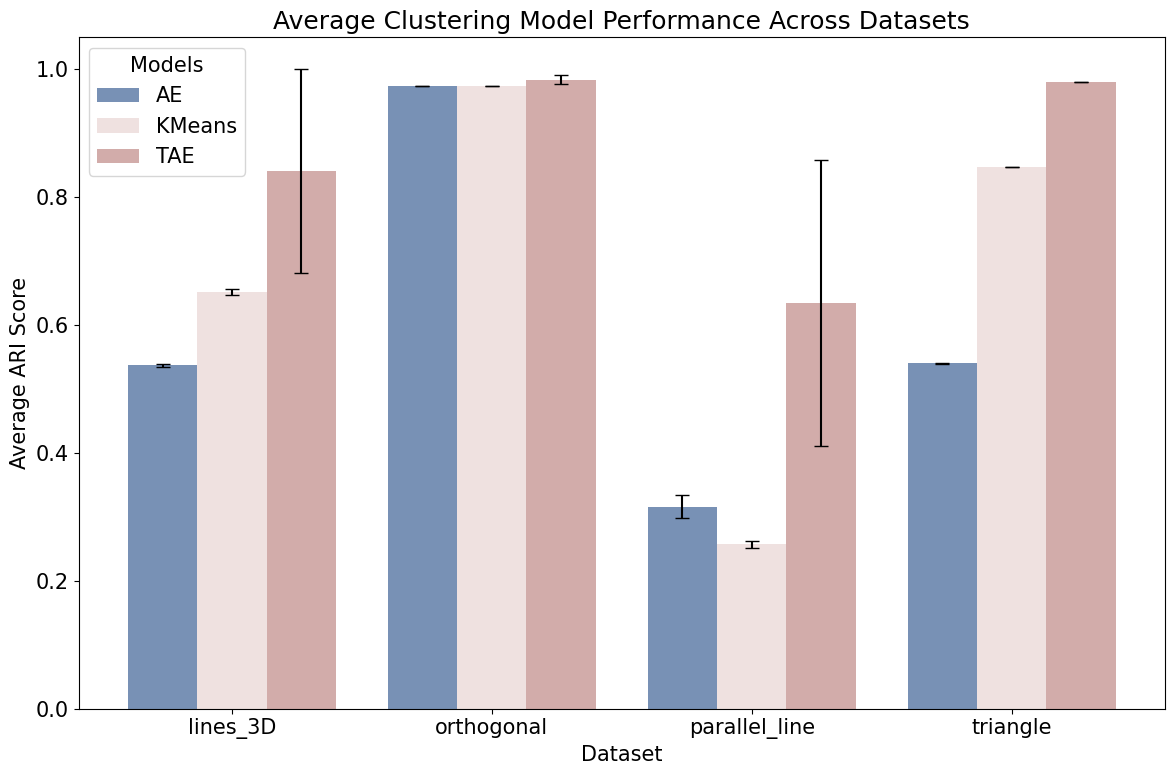

In [6]:
# Example dataset labels
datasets = ['parallel_line', 'orthogonal', 'triangle', 'lines_3D']
print()
# Flatten the ARI lists and create corresponding label lists for plotting
# Make sure ae_ari, tae_ari, kmeans_ari, shared_ari are lists of lists, where each sublist corresponds to a different dataset
all_scores = []
all_models = []
all_datasets = []
for i, dataset_name in enumerate(datasets):
    for score_list, model_name in zip([kmeans_ari, ae_ari, tae_ari], ['KMeans', 'AE', 'TAE']):
        all_scores.extend(score_list[i])
        all_models.extend([model_name] * len(score_list[i]))
        all_datasets.extend([dataset_name] * len(score_list[i]))

# Create a DataFrame for easier plotting with Seaborn
data = pd.DataFrame({'ARI Scores': all_scores, 'Models': all_models, 'Dataset': all_datasets})

mean_scores = data.groupby(['Models', 'Dataset'])['ARI Scores'].mean().reset_index()
error_scores = data.groupby(['Models', 'Dataset'])['ARI Scores'].sem().reset_index()  # sem() for standard error, std() for standard deviation

# Merge the mean and error data for plotting
plot_data = pd.merge(mean_scores, error_scores, on=['Models', 'Dataset'], suffixes=('_mean', '_error'))
n_palette = sns.color_palette("vlag") # Example palette

# Skip a color, for example, the second color
n_palette = n_palette[:1]+n_palette[3:]
# Create the bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Dataset', y='ARI Scores_mean', hue='Models', data=plot_data, palette = n_palette)

# Get the total number of bars in a single group
n_bars = len(plot_data['Models'].unique())
# The width of a group of bars
bar_width = 0.8
# Spacing between each group
group_width = n_bars * bar_width
# Individual bar width
single_bar_width = bar_width / n_bars
# Offset from the center of the group
offset = (np.arange(n_bars) - np.arange(n_bars).mean()) * single_bar_width

# Add error bars
for i, dataset in enumerate(plot_data['Dataset'].unique()):
    for j, model in enumerate(plot_data['Models'].unique()):
        subset = plot_data[(plot_data['Models'] == model) & (plot_data['Dataset'] == dataset)]
        # Calculate the position for each bar/errorbar
        # Note: +0.2 is added to align with the seaborn default, adjust this if necessary
        position = i - 0.2 + offset[j]+0.2
        plt.errorbar(x=position, y=subset['ARI Scores_mean'], yerr=subset['ARI Scores_error'], fmt='none', c='black', capsize=5)

plt.title('Average Clustering Model Performance Across Datasets')
plt.ylabel('Average ARI Score')
plt.xlabel('Dataset')
plt.legend(title='Models')
plt.tight_layout()
plt.show()

### 3.2 Deoising

In [7]:
import pandas as pd
# ae_loss and tae_loss has the mse of the data
repetition = 5
epochs = 100

np.random.seed(1)
ae_loss = []
tae_loss = []

shared_loss = []

for data_generation in [parallel_line(noise=0.1) , orthogonal(noise=0.1), triangle(noise=0.1), lines_3D(noise=0.1)]:
    ae = []
    tae = []
    
    shared = []
    
    for rep in range(repetition):
        print(rep)

        np.random.seed(rep)

        X,Y,X_noise,n_clusters = data_generation

        # Standard AE
        print("Standard AE")
        net = Autoencoder(in_feature=X.shape[1],embed=1)
        ae_l = train_AE(net, X_noise,Y, lr=0.01,epochs=epochs,X_out=X)
        ae.append(ae_l[-1])

        # Tensorized AE
        print("Tensorized AE")
        _, tae_l, _, _, _, _ = train_TAE(X_noise.clone(),Y.clone(), n_clusters=n_clusters, lr=0.1, reg=0.1, shared=(False, 1, 1), epochs=epochs, X_out=X.clone() )
        tae.append(tae_l[-1])
        
        # Shared TAE
        print("Shared TAE")
        _, shared_l, _, _, _, _ = train_TAE(X_noise.clone(),Y.clone(), n_clusters=n_clusters, lr=0.1, reg=0.1, shared=(True, 2,1), epochs=epochs, X_out=X.clone() )
        shared.append(shared_l[-1])
    
    ae_loss.append(ae)
    tae_loss.append(tae)
    
    shared_loss.append(shared)

0
Standard AE
10
Tensorized AE
20
epoch  99  loss  0.0650683148088865
Shared TAE
partly shared architecture
28
epoch  99  loss  0.02999594878250112
1
Standard AE
10
Tensorized AE
20
epoch  99  loss  0.07429399977438152
Shared TAE
partly shared architecture
28
epoch  99  loss  0.028761775135062635
2
Standard AE
10
Tensorized AE
20
epoch  99  loss  0.06550391045554231
Shared TAE
partly shared architecture
28
epoch  99  loss  0.03139098761758457
3
Standard AE
10
Tensorized AE
20
epoch  99  loss  0.06551357793544109
Shared TAE
partly shared architecture
28
epoch  99  loss  0.032967043919488785
4
Standard AE
10
Tensorized AE
20
epoch  99  loss  0.06818631900086378
Shared TAE
partly shared architecture
28
epoch  99  loss  0.029858545338890204
0
Standard AE
10
Tensorized AE
20
epoch  99  loss  0.08790308195942392
Shared TAE
partly shared architecture
28
epoch  99  loss  0.051386265065521
1
Standard AE
10
Tensorized AE
20
epoch  99  loss  0.09556798344322791
Shared TAE
partly shared architectu

4 [5, 5, 5, 5]
4 [5, 5, 5, 5]
4 [5, 5, 5, 5]
         Dataset Model      Loss
0  Parallel Line    AE  1.478475
1     Orthogonal    AE  1.478461
2       Triangle    AE  1.478475
3       Lines 3D    AE  1.478476
4  Parallel Line    AE  1.478460


/var/folders/sk/9lczs5_52kq25vck6g54sfv40000gn/T/ipykernel_17896/1764934524.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Dataset', y='Loss', hue='Model', data=df, palette='vlag', ci=None)  # No confidence intervals from Seaborn


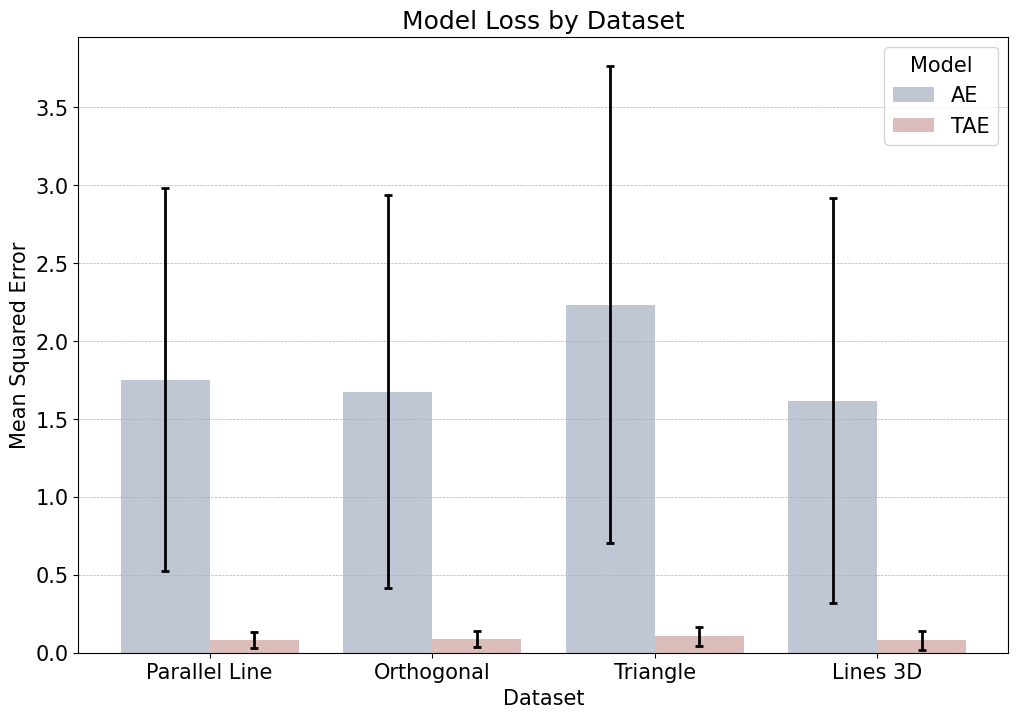

In [8]:
import pandas as pd
print(len(ae_loss), [len(losses) for losses in ae_loss])
print(len(tae_loss), [len(losses) for losses in tae_loss])
print(len(shared_loss), [len(losses) for losses in shared_loss])

# Let's break down the data construction to avoid confusion
# Initialize lists to hold the data
dataset_list = ['Parallel Line', 'Orthogonal', 'Triangle', 'Lines 3D'] * 2 * 5  # Repeat for each model and repetition
model_list = (['AE'] * 20 + ['TAE'] * 20 )  # 3 models, 4 datasets, 5 repetitions  + ['Shared TAE'] * 20
loss_list = [item for sublist in ae_loss for item in sublist] + \
            [item for sublist in tae_loss for item in sublist] # + \
            #[item for sublist in shared_loss for item in sublist]  # Flatten the loss lists

# Create the DataFrame
df = pd.DataFrame({
    'Dataset': dataset_list,
    'Model': model_list,
    'Loss': loss_list
})

# Let's visualize the first few rows to ensure it's correct
print(df.head())

# If the DataFrame looks correct, proceed with the plotting
means = df.groupby(['Dataset', 'Model'], as_index=False)['Loss'].mean()
stds = df.groupby(['Dataset', 'Model'], as_index=False)['Loss'].std()

# Start plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Dataset', y='Loss', hue='Model', data=df, palette='vlag', ci=None)  # No confidence intervals from Seaborn

# Now, add the error bars
# Unique datasets and models for positioning
datasets = df['Dataset'].unique()
models = df['Model'].unique()

# Width of a bar:
bar_width = 0.2
# Spacing:
spacing = np.linspace(-bar_width, bar_width, len(models))

# Add error bars
for i, dataset in enumerate(datasets):
    for j, model in enumerate(models):
        # Find the mean and std for this dataset-model combination
        mean = means[(means['Dataset'] == dataset) & (means['Model'] == model)]['Loss'].values[0]
        std = stds[(stds['Dataset'] == dataset) & (stds['Model'] == model)]['Loss'].values[0]
        # Position of the error bar
        position = i + spacing[j] 
        plt.errorbar(position, mean, yerr=std, fmt='none', ecolor='black', capsize=3, capthick=2, elinewidth=2)

# Final touches
plt.title('Model Loss by Dataset')
plt.ylabel('Mean Squared Error')
plt.xlabel('Dataset')
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')  # Horizontal gridlines
plt.legend(title='Model')
plt.xticks(range(len(datasets)), datasets)  # Ensure dataset labels are correctly positioned
plt.show()

### 3.3 PTAE

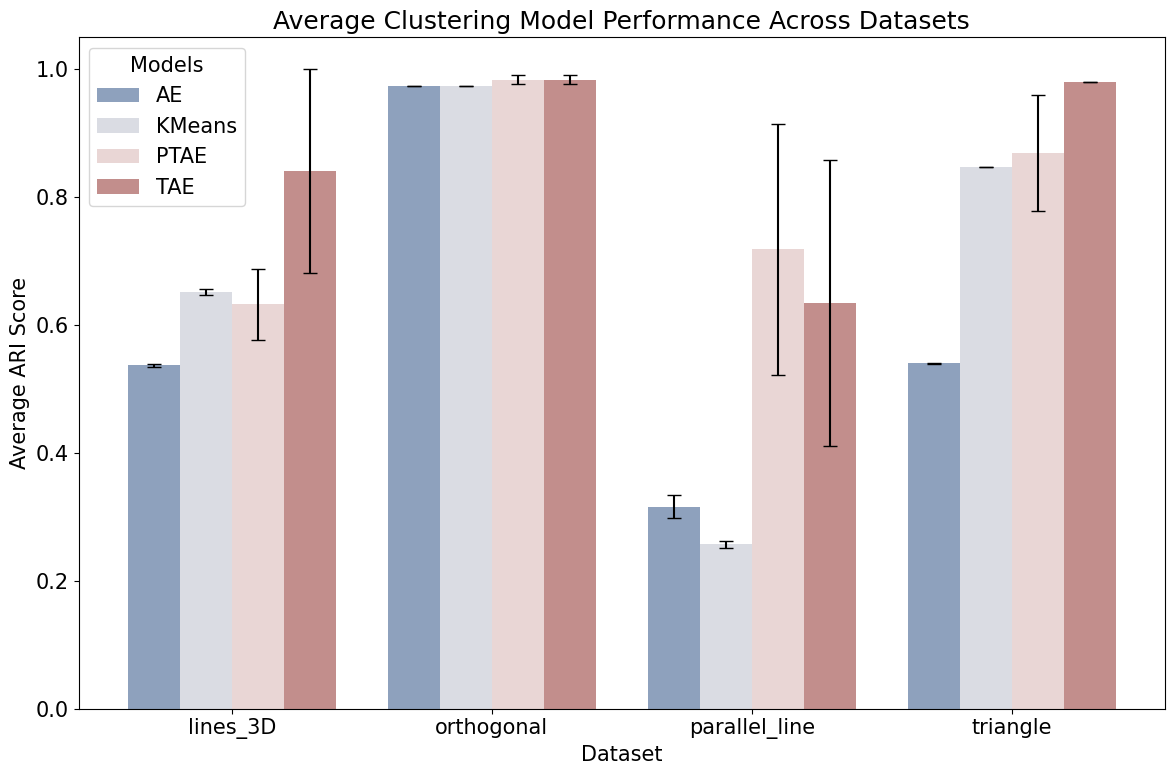

In [9]:
# Example dataset labels
datasets = ['parallel_line', 'orthogonal', 'triangle', 'lines_3D']
print()
# Flatten the ARI lists and create corresponding label lists for plotting
# Make sure ae_ari, tae_ari, kmeans_ari, shared_ari are lists of lists, where each sublist corresponds to a different dataset
all_scores = []
all_models = []
all_datasets = []
for i, dataset_name in enumerate(datasets):
    for score_list, model_name in zip([kmeans_ari, ae_ari, tae_ari,shared_ari], ['KMeans', 'AE', 'TAE','PTAE']):
        all_scores.extend(score_list[i])
        all_models.extend([model_name] * len(score_list[i]))
        all_datasets.extend([dataset_name] * len(score_list[i]))

# Create a DataFrame for easier plotting with Seaborn
data = pd.DataFrame({'ARI Scores': all_scores, 'Models': all_models, 'Dataset': all_datasets})

mean_scores = data.groupby(['Models', 'Dataset'])['ARI Scores'].mean().reset_index()
error_scores = data.groupby(['Models', 'Dataset'])['ARI Scores'].sem().reset_index()  # sem() for standard error, std() for standard deviation

# Merge the mean and error data for plotting
plot_data = pd.merge(mean_scores, error_scores, on=['Models', 'Dataset'], suffixes=('_mean', '_error'))

# Create the bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Dataset', y='ARI Scores_mean', hue='Models', data=plot_data, palette = "vlag")

# Get the total number of bars in a single group
n_bars = len(plot_data['Models'].unique())
# The width of a group of bars
bar_width = 0.8
# Spacing between each group
group_width = n_bars * bar_width
# Individual bar width
single_bar_width = bar_width / n_bars
# Offset from the center of the group
offset = (np.arange(n_bars) - np.arange(n_bars).mean()) * single_bar_width

# Add error bars
for i, dataset in enumerate(plot_data['Dataset'].unique()):
    for j, model in enumerate(plot_data['Models'].unique()):
        subset = plot_data[(plot_data['Models'] == model) & (plot_data['Dataset'] == dataset)]
        # Calculate the position for each bar/errorbar
        # Note: +0.2 is added to align with the seaborn default, adjust this if necessary
        position = i - 0.2 + offset[j]+0.2
        plt.errorbar(x=position, y=subset['ARI Scores_mean'], yerr=subset['ARI Scores_error'], fmt='none', c='black', capsize=5)

plt.title('Average Clustering Model Performance Across Datasets')
plt.ylabel('Average ARI Score')
plt.xlabel('Dataset')
plt.legend(title='Models')
plt.tight_layout()
plt.show()

### 3.4 Clustering Visualization

In [10]:
# kmeans_ari, ae_ari, tae_ari gives the ari of respective algorithms
# hyperparameters: repetition, epochs, lr, reg,  

np.random.seed(24)
ae_ari = []
tae_ari = []
kmeans_ari = []
shared_ari = []

plot_kmeans = []
plot_ae = []
plot_tae = []
plot_stae = []

X_plot = []
arcs_plot = []

for (data_generation, lr,epochs) in [
                            (parallel_line(noise=0), 0.01, 150), 
                            (orthogonal(noise=0), 0.01, 100), 
                            (triangle(noise=0),0.1, 150), 
                            (lines_3D(noise=0),0.1, 150)
                             ]:
    print("shape of dataset: ", data_generation[0].shape)
    
    ae = []
    tae = []
    kmeans_ = []
    shared = []
    X,Y,X_noise,n_clusters = data_generation
    x_idx = torch.tensor(np.arange(X.shape[0]))
    shuffle_idx = torch.randperm(x_idx.shape[0])
    x_idx = x_idx[shuffle_idx]
    # X = torch.tensor(X[x_idx], dtype=torch.float32)
    # Y = torch.tensor(Y[x_idx], dtype=torch.float32)
    X = X[x_idx].float().to(device)
    Y = Y[x_idx].float().to(device)

    X_plot.append(X)
    
    # k means
    k = KMeans(n_clusters=n_clusters, random_state=rep,n_init=10).fit(X.cpu())
    k_ari = adjusted_rand_score(k.labels_, Y.cpu())
    kmeans_.append(k_ari)
    
    # Standard AE
    # print("standard AE:")
    net = Autoencoder(in_feature=X.shape[1],embed=1).to(device)
    ae_l = train_AE(net,X.clone(),Y.clone(), lr=0.01,epochs=epochs)
    X_embed = net.enc1(X).cpu().detach().numpy()
    kmeans = KMeans(n_clusters=n_clusters, random_state=0,n_init=10).fit(X_embed)
    AE_clust_assign = kmeans.labels_
    ari = adjusted_rand_score(AE_clust_assign, Y.cpu())
    ae.append(ari)
    
    # Tensorized AE
    # print("Tensorized AE:")
    _, tae_l, TAE_clust_assign, _, _, _ = train_TAE(X.clone(),Y.clone(), n_clusters=n_clusters, lr=lr, reg=0.1,  shared=(False, 1, 1), epochs=epochs)
    ari = adjusted_rand_score(torch.argmax(TAE_clust_assign,axis=0).cpu().detach().numpy(), Y.cpu())
    tae.append(ari)
    
    # Shared TAE
    # print("Shared TAE:")
    _, shared_l, SHARED_clust_assign, _, _, _ = train_TAE(X.clone(),Y.clone(), n_clusters=n_clusters, lr=lr, reg=0.1, epochs=epochs,shared=(True, 2, 1))
    ari = adjusted_rand_score(torch.argmax(SHARED_clust_assign,axis=0).cpu().detach().numpy(), Y.cpu())
    shared.append(ari)
    
    arcs = [
        KMeans(n_clusters=n_clusters, random_state=24,n_init=10).fit_predict(X),
        KMeans(n_clusters=n_clusters, random_state=24,n_init=10).fit_predict(X_embed),
        torch.argmax(TAE_clust_assign,axis=0).cpu().detach().numpy(),
        torch.argmax(SHARED_clust_assign,axis=0).cpu().detach().numpy()
        ]
    arcs_plot.append(arcs)          
    kmeans_ari.append(kmeans_)   
    ae_ari.append(ae)
    tae_ari.append(tae)
    shared_ari.append(shared)

shape of dataset:  torch.Size([150, 5])
10
20
epoch  149  loss  0.2642010325208927
partly shared architecture
28
epoch  149  loss  0.2178645863197744
shape of dataset:  torch.Size([150, 5])
10
20
epoch  99  loss  1.0021658935459952
partly shared architecture
28
epoch  99  loss  0.7517296085258325
shape of dataset:  torch.Size([150, 5])
10
30
epoch  149  loss  0.1524440943612717
partly shared architecture
32
epoch  149  loss  0.12372916641955574
shape of dataset:  torch.Size([300, 6])
12
36
epoch  149  loss  0.0199865992697111
partly shared architecture
36
epoch  149  loss  0.12219583258226824


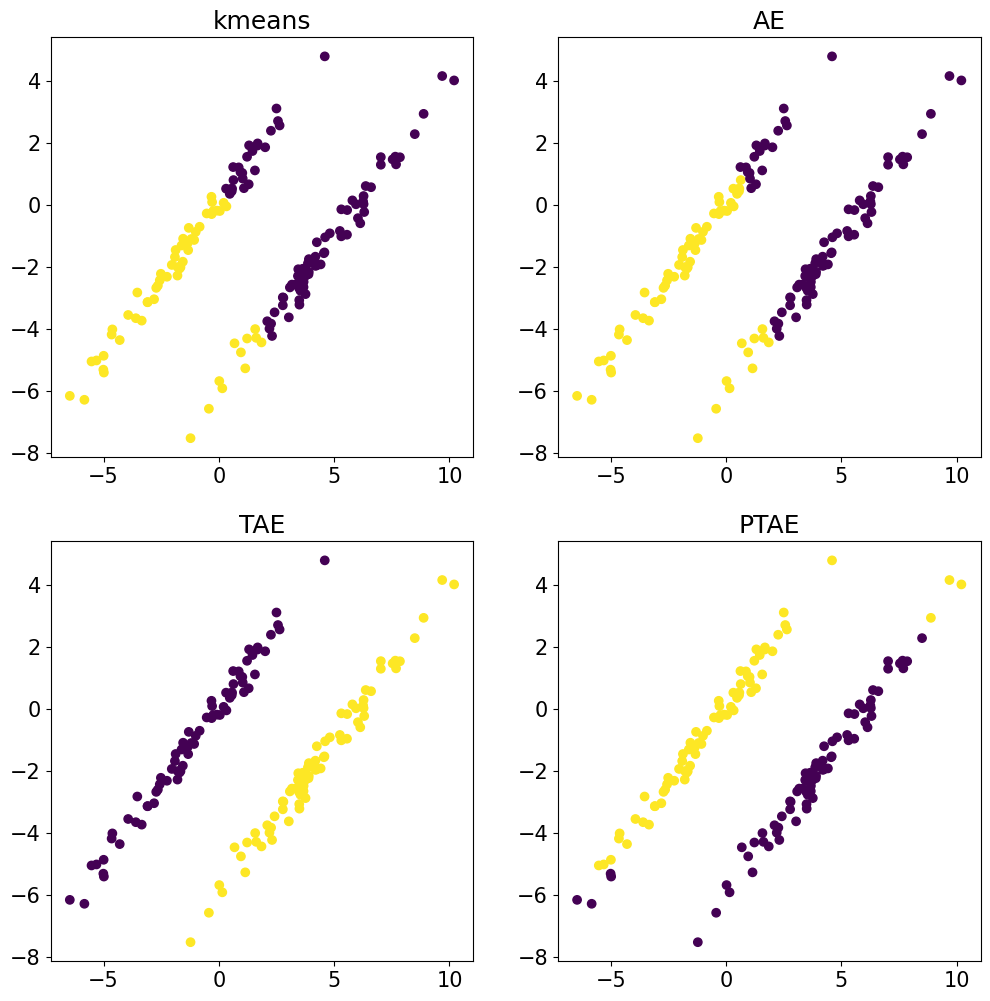

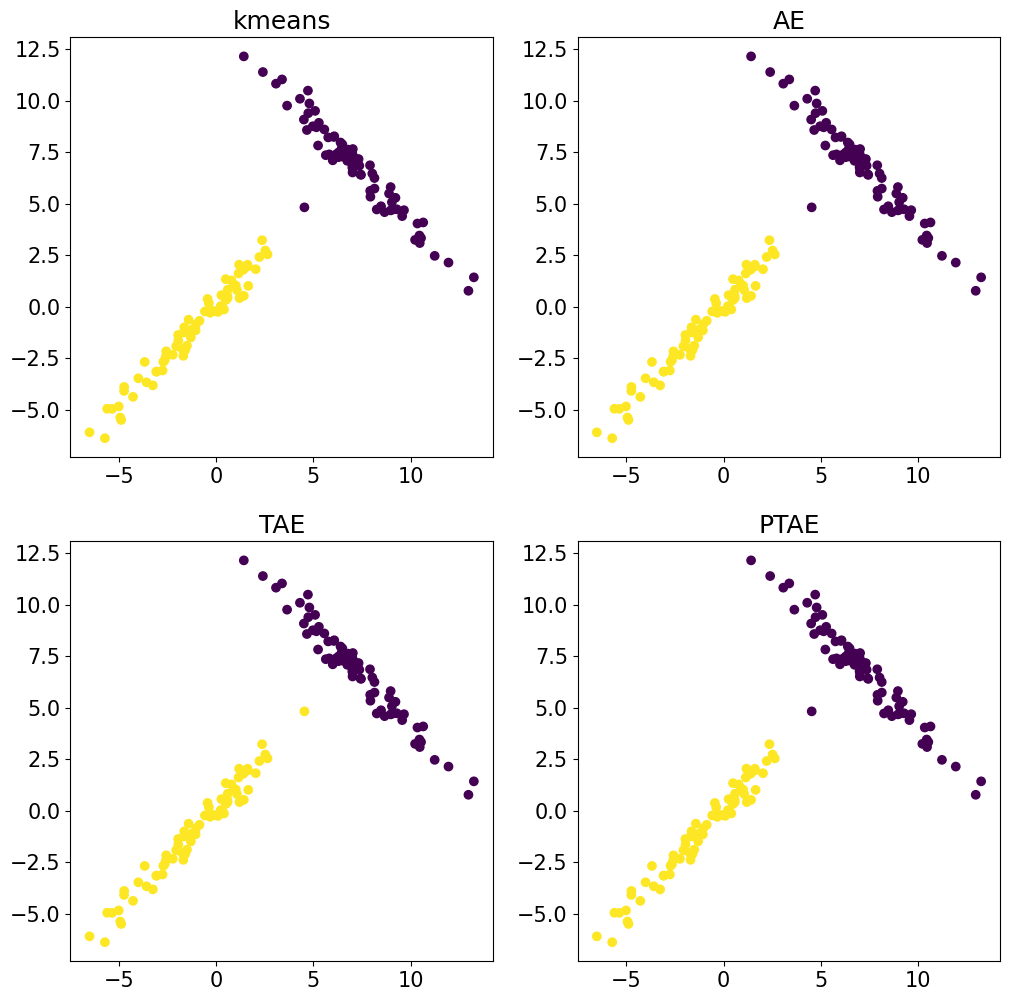

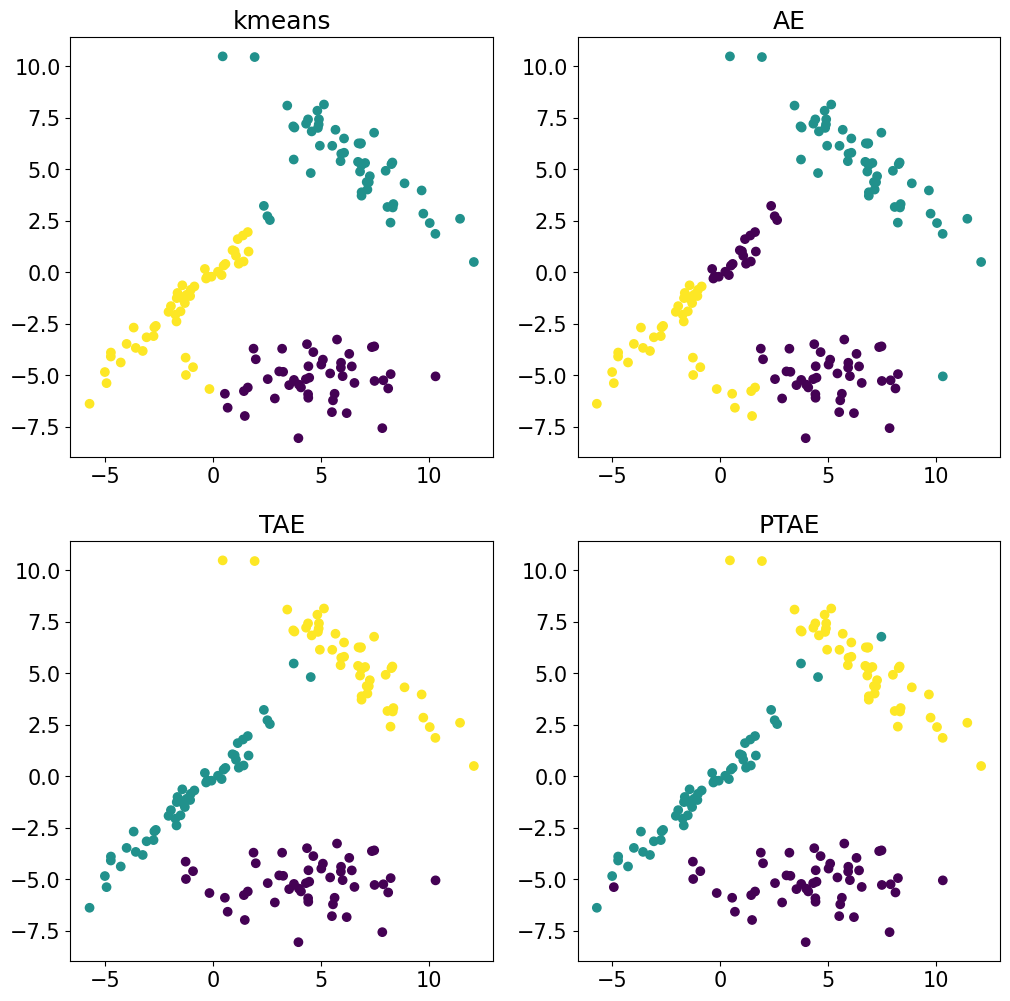

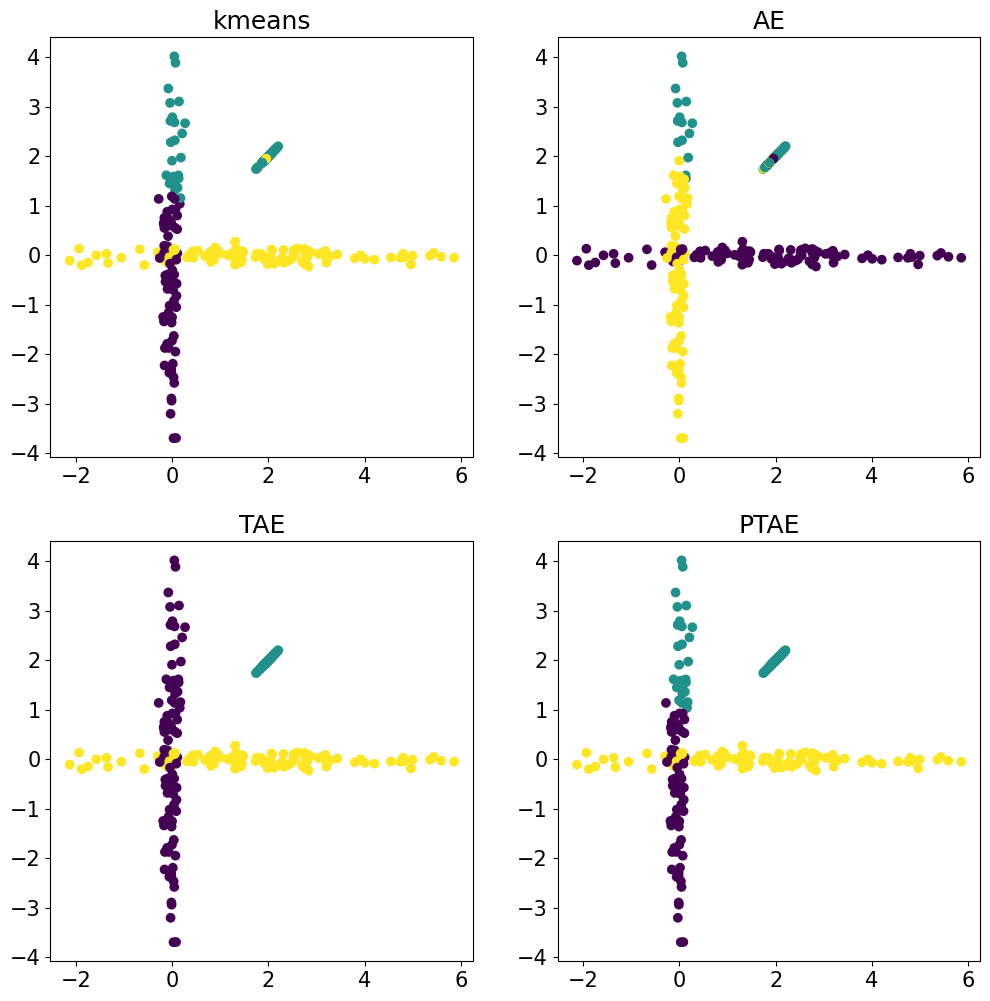

In [11]:
for j in range(4):
    titles = ['kmeans', 'AE', 'TAE', 'PTAE']
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    arcs = arcs_plot[j]
    X = X_plot[j]
    for i in range(len(arcs)):
        y_pred = arcs[i]
        axs[i//2, i%2].scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis')
        axs[i//2, i%2].set_title(titles[i])

### 3.5 TAE1 TAE2 PTAE

In [13]:
def summarize_size(model, name):
    total_params = sum(p.numel() for p in model.parameters())
    model_size_bytes = total_params * 4  # for float32 parameters
    model_size_mb = model_size_bytes*8 / (1024 * 1024)
    print("Model: ", name)
    print('params: ', total_params)
    print(f'Model size: {model_size_mb:.2f} Mbit')

repetition = 5
epochs = 100
printing = False
linear = True
kmeans_ari = []
ae_ari_1 = []
ae_ari_2 = []
tae_ari1 = []
tae_ari2 = []

shared_ari = []

models = []
datasets = [
    ('penguin4', [0,1,2], True, False, False, 1, 3,False),
    ('iris', [0,1,2], False, False, False, 1, 3,False),
    ('mnist', [0,1,2,3,4], True, True, False, 10, 5,True),
    ('fashion', [0,1,2], False, True, False, 10, 3, False)
]

for (dataset, class_label, normalise, subsample, CNN, d, k, sig) in datasets:
    kmeans = []
    ae1 = []
    ae2 = []
    tae1 = []
    tae2 = []
    shared = []
    
    
    for r in range(repetition):

        ##################################
        # penguin 4 Features
        ##################################

        # load data

        X,Y = real_data_loader(dataset=dataset, class_labels_list=class_label, normalise_data=normalise, subsample=subsample)
        n_clusters = k

        # k-means Benchmark
        k_ = KMeans(n_clusters=n_clusters, random_state=r, n_init=10).fit(X)
        kmeans.append(adjusted_rand_score(k_.labels_, Y.cpu().detach().numpy()))

        # simple AE embedding 1 
        print("simple AE embedding 1:")
        if CNN:
            net1 = CNN_Autoencoder(embed=d).to(device)
        else:
            net1 = Autoencoder(in_feature=X.shape[1],embed=d,linear=linear).to(device)
        train_loss = train_AE(net1, X.float(),Y.float(), lr=0.001,epochs=epochs, CNN=CNN)
        
        X_embed = net1.enc1(X.float().to(device)).cpu().detach().numpy()
        kmeans_ = KMeans(n_clusters=n_clusters, random_state=0,n_init=10).fit(X_embed)

        ae1.append(adjusted_rand_score(kmeans_.labels_, Y.cpu().detach().numpy()))

        # simple AE embedding 3
        if CNN:
            net2 = CNN_Autoencoder(embed=d*k).to(device)
        else:
            net2 = Autoencoder(in_feature=X.shape[1],embed=d*k,linear=linear).to(device)
        train_loss = train_AE(net2, X.float(),Y.float(), lr=0.001,epochs=epochs, CNN=CNN)

        X_embed = net2.enc1(X.float().to(device)).cpu().detach().numpy()
        kmeans_ = KMeans(n_clusters=n_clusters, random_state=0,n_init=10).fit(X_embed)

        ae2.append(adjusted_rand_score(kmeans_.labels_, Y.cpu().detach().numpy()))

        print("TAE1:")
        tae1_net, train_loss1, clust_assign1, _, Y_t1, _ = train_TAE(X.float().clone(),Y.float().clone(), n_clusters= n_clusters , lr=0.01, reg=0.1,shared=(False, d, d), linear=linear, epochs=epochs ,number_of_batches=1, CNN=CNN,printing=printing)
        tae1.append(adjusted_rand_score(torch.argmax(clust_assign1,axis=0).cpu().detach().numpy(), Y_t1.cpu().detach().numpy()))

        print("TAE2:")
        tae2_net, train_loss2, clust_assign2, _, Y_t2, _ = train_TAE(X.float().clone(),Y.float().clone(), n_clusters= n_clusters , lr=0.01, reg=0.1,shared=(False, d*k, d), linear=linear, epochs=epochs ,number_of_batches=1, CNN=CNN,printing=printing)
        tae2.append(adjusted_rand_score(torch.argmax(clust_assign2,axis=0).cpu().detach().numpy(), Y_t2.cpu().detach().numpy()))

        # Shared TAE
        print("Shared TAE:")
        stae_net, shared_train_loss, shared_clust_assign, _, shared_Y_t, _ = train_TAE(X.float().clone(),Y.float().clone(), n_clusters= n_clusters , lr=0.1, reg=0.1, shared=(True, d*k, d), linear=linear, epochs=epochs ,number_of_batches=1, CNN=CNN,printing=printing, sig=False)
        shared.append(adjusted_rand_score(torch.argmax(shared_clust_assign,axis=0).cpu().detach().numpy(), shared_Y_t.cpu().detach().numpy()))
    kmeans_ari.append(kmeans)
    ae_ari_1.append(ae1)
    ae_ari_2.append(ae2)
    tae_ari1.append(tae1)
    tae_ari2.append(tae2)
    shared_ari.append(shared)
    models.append((net1, 'AE1'))
    models.append((net2, 'AE2'))
    models.append((tae1_net, 'TAE1'))
    models.append((tae2_net, 'TAE1'))
    models.append((stae_net, 'PTAE'))


simple AE embedding 1:
8
24
TAE1:
24
epoch  99  loss  0.0011275095960240696
TAE2:
90
epoch  99  loss  0.0008627414522298004
Shared TAE:
partly shared architecture
42
epoch  99  loss  0.0007698061847091202
simple AE embedding 1:
8
24
TAE1:
24
epoch  99  loss  0.0016733971586830026
TAE2:
90
epoch  99  loss  0.0008334671535908592
Shared TAE:
partly shared architecture
42
epoch  99  loss  0.0007660978514328878
simple AE embedding 1:
8
24
TAE1:
24
epoch  99  loss  0.0013553391197860321
TAE2:
90
epoch  99  loss  0.0008360156918494038
Shared TAE:
partly shared architecture
42
epoch  99  loss  0.0009121159950873716
simple AE embedding 1:
8
24
TAE1:
24
epoch  99  loss  0.001314207891297344
TAE2:
90
epoch  99  loss  0.0013804440572086692
Shared TAE:
partly shared architecture
42
epoch  99  loss  0.0009023644714709476
simple AE embedding 1:
8
24
TAE1:
24
epoch  99  loss  0.0012950433441158943
TAE2:
90
epoch  99  loss  0.0009797943070399575
Shared TAE:
partly shared architecture
42
epoch  99  loss

/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_full[x_idx], dtype=torch.float)
/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y_full[x_idx])


78400
TAE1:
78400
epoch  99  loss  2570.0071142578126
TAE2:
397000
epoch  99  loss  1860.7865244140626
Shared TAE:
partly shared architecture
83400
epoch  99  loss  nan
MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Number of total samples  torch.Size([250])
simple AE embedding 1:
15680


/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_full[x_idx], dtype=torch.float)
/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y_full[x_idx])


78400
TAE1:
78400
epoch  99  loss  2361.954594116211
TAE2:
397000
epoch  99  loss  1866.917326538086
Shared TAE:
partly shared architecture
83400
epoch  99  loss  nan
MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Number of total samples  torch.Size([250])
simple AE embedding 1:
15680


/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_full[x_idx], dtype=torch.float)
/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y_full[x_idx])


78400
TAE1:
78400
epoch  99  loss  2483.25884375
TAE2:
397000
epoch  99  loss  1729.9059298095704
Shared TAE:
partly shared architecture
83400
epoch  99  loss  nan
MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Number of total samples  torch.Size([250])
simple AE embedding 1:
15680


/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_full[x_idx], dtype=torch.float)
/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y_full[x_idx])


78400
TAE1:
78400
epoch  99  loss  2313.479418212891
TAE2:
397000
epoch  99  loss  1776.3812615966797
Shared TAE:
partly shared architecture
83400
epoch  99  loss  nan
MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Number of total samples  torch.Size([250])
simple AE embedding 1:
15680


/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_full[x_idx], dtype=torch.float)
/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y_full[x_idx])


78400
TAE1:
78400
epoch  99  loss  2327.1179814453126
TAE2:
397000
epoch  99  loss  1708.5882001953125
Shared TAE:
partly shared architecture
83400
epoch  99  loss  nan
Fashion MNIST loaded dataset Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Number of total samples  torch.Size([150])
simple AE embedding 1:
15680


/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_full[x_idx], dtype=torch.float)
/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y_full[x_idx])


47040
TAE1:
47040
epoch  99  loss  2392.6479400634767
TAE2:
142920
epoch  99  loss  3029.507460123698
Shared TAE:
partly shared architecture
48840
epoch  99  loss  3279.0218762207032
Fashion MNIST loaded dataset Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Number of total samples  torch.Size([150])
simple AE embedding 1:
15680


/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_full[x_idx], dtype=torch.float)
/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y_full[x_idx])


47040
TAE1:
47040
epoch  99  loss  2267.320845743815
TAE2:
142920
epoch  99  loss  2649.7256522623697
Shared TAE:
partly shared architecture
48840
epoch  99  loss  nan
Fashion MNIST loaded dataset Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Number of total samples  torch.Size([150])
simple AE embedding 1:
15680


/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_full[x_idx], dtype=torch.float)
/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y_full[x_idx])


47040
TAE1:
47040
epoch  99  loss  2079.3208756510417
TAE2:
142920
epoch  99  loss  2026.453317260742
Shared TAE:
partly shared architecture
48840
epoch  99  loss  nan
Fashion MNIST loaded dataset Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Number of total samples  torch.Size([150])
simple AE embedding 1:
15680


/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_full[x_idx], dtype=torch.float)
/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y_full[x_idx])


47040
TAE1:
47040
epoch  99  loss  2470.901265869141
TAE2:
142920
epoch  99  loss  1922.4398002115886
Shared TAE:
partly shared architecture
48840
epoch  99  loss  2713.883220621745
Fashion MNIST loaded dataset Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Number of total samples  torch.Size([150])
simple AE embedding 1:
15680


/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_full[x_idx], dtype=torch.float)
/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y_full[x_idx])


47040
TAE1:
47040
epoch  99  loss  2844.1060595703125
TAE2:
142920
epoch  99  loss  1574.6716935221355
Shared TAE:
partly shared architecture
48840
epoch  99  loss  3202.6045263671876


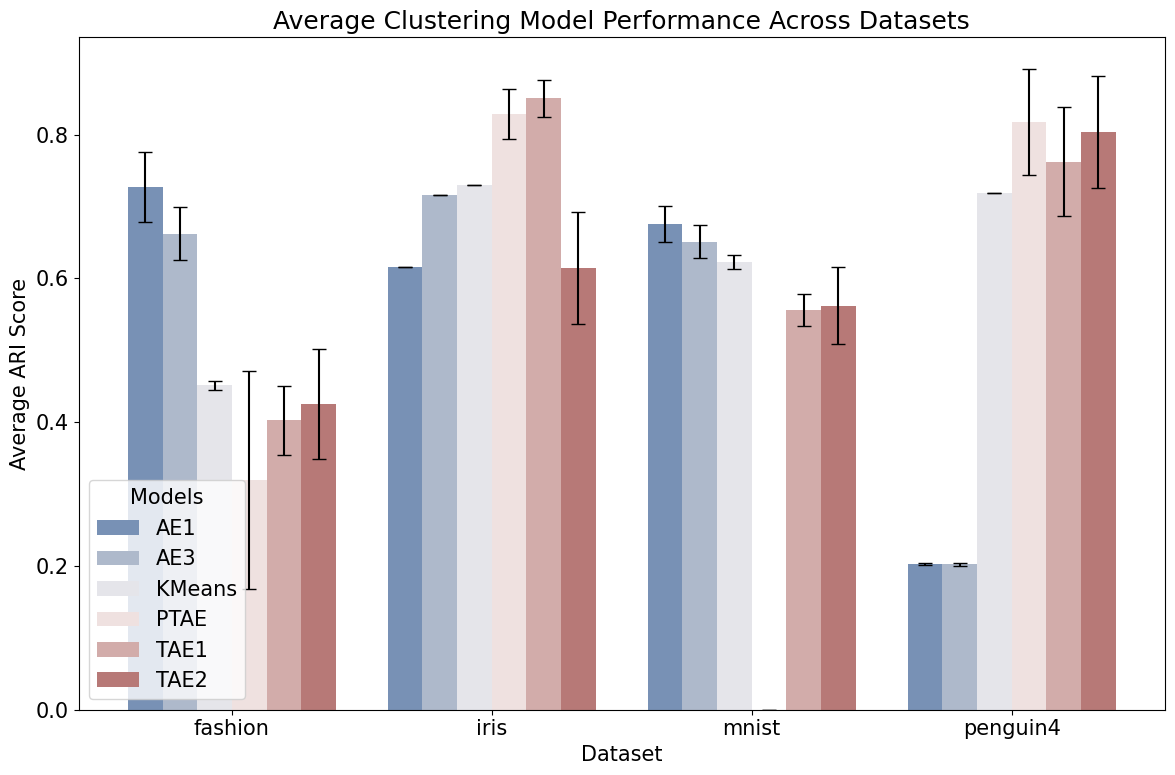

In [14]:
# Example dataset labels
datasets = ['penguin4', 'iris', 'mnist', 'fashion'] 

# Flatten the ARI lists and create corresponding label lists for plotting
# Make sure ae_ari, tae_ari, kmeans_ari, shared_ari are lists of lists, where each sublist corresponds to a different dataset
all_scores = []
all_models = []
all_datasets = []
for i, dataset_name in enumerate(datasets):
    for score_list, model_name in zip([kmeans_ari, ae_ari_1, ae_ari_2, tae_ari1,tae_ari2, shared_ari], ['KMeans', 'AE1', 'AE3', 'TAE1', 'TAE2', 'PTAE']):
        all_scores.extend(score_list[i])
        all_models.extend([model_name] * len(score_list[i]))
        all_datasets.extend([dataset_name] * len(score_list[i]))

# Create a DataFrame for easier plotting with Seaborn
data = pd.DataFrame({'ARI Scores': all_scores, 'Models': all_models, 'Dataset': all_datasets})

# Names of datasets
datasets = ['penguin4', 'iris']

mean_scores = data.groupby(['Models', 'Dataset'])['ARI Scores'].mean().reset_index()
error_scores = data.groupby(['Models', 'Dataset'])['ARI Scores'].sem().reset_index()  # sem() for standard error, std() for standard deviation

# Merge the mean and error data for plotting
plot_data = pd.merge(mean_scores, error_scores, on=['Models', 'Dataset'], suffixes=('_mean', '_error'))

# Create the bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Dataset', y='ARI Scores_mean', hue='Models', data=plot_data, palette = "vlag")

# Get the total number of bars in a single group
n_bars = len(plot_data['Models'].unique())
# The width of a group of bars
bar_width = 0.8
# Spacing between each group
group_width = n_bars * bar_width
# Individual bar width
single_bar_width = bar_width / n_bars
# Offset from the center of the group
offset = (np.arange(n_bars) - np.arange(n_bars).mean()) * single_bar_width

# Add error bars
for i, dataset in enumerate(plot_data['Dataset'].unique()):
    for j, model in enumerate(plot_data['Models'].unique()):
        subset = plot_data[(plot_data['Models'] == model) & (plot_data['Dataset'] == dataset)]
        # Calculate the position for each bar/errorbar
        # Note: +0.2 is added to align with the seaborn default, adjust this if necessary
        position = i - 0.2 + offset[j]+0.2
        plt.errorbar(x=position, y=subset['ARI Scores_mean'], yerr=subset['ARI Scores_error'], fmt='none', c='black', capsize=5)

plt.title('Average Clustering Model Performance Across Datasets')
plt.ylabel('Average ARI Score')
plt.xlabel('Dataset')
plt.legend(title='Models')
plt.tight_layout()
plt.show()

### Table 3.1

In [15]:
for i in range(len(models)):
 summarize_size(models[i][0], models[i][1])


Model:  AE1
params:  8
Model size: 0.00 Mbit
Model:  AE2
params:  24
Model size: 0.00 Mbit
Model:  TAE1
params:  24
Model size: 0.00 Mbit
Model:  TAE1
params:  90
Model size: 0.00 Mbit
Model:  PTAE
params:  42
Model size: 0.00 Mbit
Model:  AE1
params:  8
Model size: 0.00 Mbit
Model:  AE2
params:  24
Model size: 0.00 Mbit
Model:  TAE1
params:  24
Model size: 0.00 Mbit
Model:  TAE1
params:  90
Model size: 0.00 Mbit
Model:  PTAE
params:  42
Model size: 0.00 Mbit
Model:  AE1
params:  15680
Model size: 0.48 Mbit
Model:  AE2
params:  78400
Model size: 2.39 Mbit
Model:  TAE1
params:  78400
Model size: 2.39 Mbit
Model:  TAE1
params:  397000
Model size: 12.12 Mbit
Model:  PTAE
params:  83400
Model size: 2.55 Mbit
Model:  AE1
params:  15680
Model size: 0.48 Mbit
Model:  AE2
params:  47040
Model size: 1.44 Mbit
Model:  TAE1
params:  47040
Model size: 1.44 Mbit
Model:  TAE1
params:  142920
Model size: 4.36 Mbit
Model:  PTAE
params:  48840
Model size: 1.49 Mbit


### 3.6 Time Measuring 

In [16]:
import time
reps = 50 

for (data_generation,lr,reg,epochs) in [
                                   (orthogonal(noise=0), 0.01, 0.01, 60)]: #reg=0.001         : 28-34NaN 0.6
    X,Y,X_noise,n_clusters = data_generation
    
    start_time_tae_batch = time.time()
    for i in range(reps):
        embeddings, assign, loss, _ = train_batch_TAE(X.clone(),Y.clone(), reg=reg, embed=1, epochs=epochs, lr=lr,n_tensors=n_clusters)
    time_taken_tae_batch = time.time() - start_time_tae_batch
    
    start_time_tae_old = time.time()
    for i in range(reps):
        # OLD TAE
        #self, n_tensors, in_feature, fst_embed, snd_embed, linear=True, CNN=False
        tae1_net, train_loss1, clust_assign1, _, Y_t1, _ = train_TAE(X.float().clone(),Y.float().clone(), n_clusters= n_clusters , lr=0.01, reg=0.1,shared=(False, d, d), linear=linear, epochs=epochs ,number_of_batches=1) 
    time_taken_tae_old = time.time() - start_time_tae_old

200
epoch  59  loss  0.3546272352260227
200
epoch  59  loss  0.3405217714856068
200
epoch  59  loss  0.47280603451964753
200
epoch  59  loss  0.39830279055982826
200
epoch  59  loss  0.40326468769926577
200
epoch  59  loss  0.499408792272831
200
epoch  59  loss  0.3433819769260784
200
epoch  59  loss  0.3813825188359867
200
epoch  59  loss  0.36150908213264
200
epoch  59  loss  0.37549387556500735
200
epoch  59  loss  0.40991534968217214
200
epoch  59  loss  0.31977483628317716
200
epoch  59  loss  0.3905102031864226
200
epoch  59  loss  0.4166245319865023
200
epoch  59  loss  0.33061350429741043
200
epoch  59  loss  0.3662899873436739
200
epoch  59  loss  0.37610231776411335
200
epoch  59  loss  0.3882428552551816
200
epoch  59  loss  0.2854683716067423
200
epoch  59  loss  0.45274002871476116
200
epoch  59  loss  0.34096541720752915
200
epoch  59  loss  0.3895119811920449
200
epoch  59  loss  0.40733679047164817
200
epoch  59  loss  0.3229217795748264
200
epoch  59  loss  0.341853061

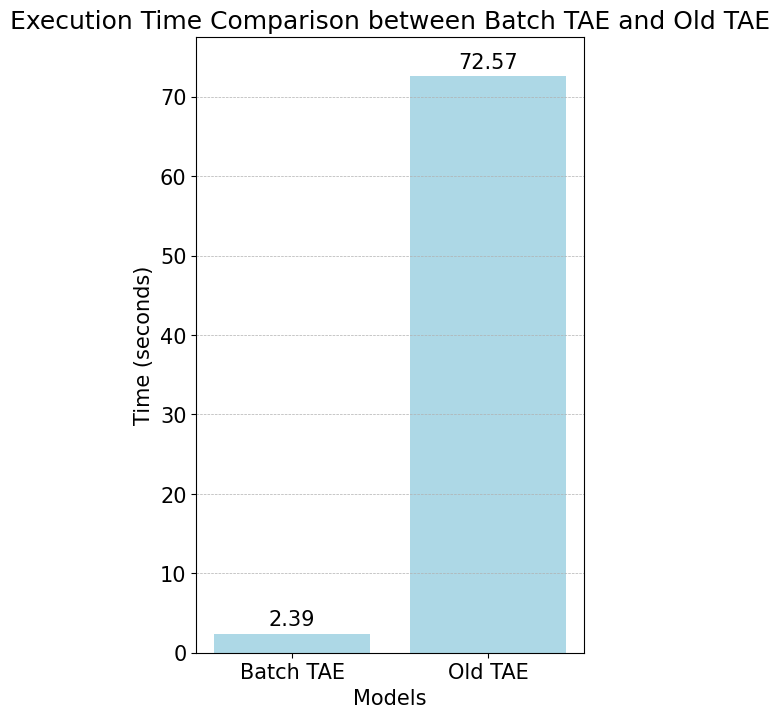

In [17]:
models = ['Batch TAE', 'Old TAE']
times = [time_taken_tae_batch, time_taken_tae_old]

plt.figure(figsize=[5,8])
plt.bar(models, times, color=['lightblue'])
plt.title('Execution Time Comparison between Batch TAE and Old TAE')
plt.xlabel('Models')
plt.ylabel('Time (seconds)')
plt.ylim(0, max(times) + 5)  # Add some space above the tallest bar for better visualization
for i, time in enumerate(times):
    plt.text(i, time + 0.5, f'{time:.2f}', ha='center', va='bottom')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.show()

### 3.7 NaN vs Performance Analysis 

In [18]:
tae_ari_old=[]
tae_ari_batch=[]
reps = 50                              
for (data_generation,lr,reg,epochs) in [
                                   (orthogonal(noise=0), 0.01, 0.01, 60), 
                                   ]: 
    clust_assign_old = []
    clust_assign_batch = []
    X,Y,X_noise,n_clusters = data_generation
    for i in range(reps):
        
        embeddings, assign, loss,_ = train_batch_TAE(X.clone(),Y.clone(), reg=reg, embed=1, epochs=epochs, lr=lr,n_tensors=n_clusters)
        if not math.isnan(loss[-1]):
            mm = [e.detach() for e in embeddings]
            k = KMeans(n_clusters=n_clusters, random_state=i,n_init=10).fit(mm)
            clust_assign_batch.append(adjusted_rand_score(assign, Y))
        tae1_net, train_loss1, clust_assign1, _, Y_t1, _ = train_TAE(X.float().clone(),Y.float().clone(), n_clusters= n_clusters , lr=0.01, reg=0.1,shared=(False, d, d), linear=linear, epochs=epochs ,number_of_batches=1)
        clust_assign_old.append(adjusted_rand_score(torch.argmax(clust_assign1,axis=0).cpu().detach().numpy(), Y.cpu().detach().numpy()))
    tae_ari_batch.append(clust_assign_batch)
    tae_ari_old.append(clust_assign_old)


200
epoch  59  loss  0.33866243017837405
200
epoch  59  loss  0.3414671343409767
200
epoch  59  loss  0.3009464033848296
200
epoch  59  loss  0.32866967518813905
200
epoch  59  loss  0.3566992569870005
200
epoch  59  loss  0.39044980811110386
200
epoch  59  loss  0.3622117590873192
200
epoch  59  loss  0.3867891040878991
200
epoch  59  loss  0.37812694953133663
200
epoch  59  loss  0.4413331945737203
200
epoch  59  loss  0.3008559943844254
200
epoch  59  loss  0.4446176795195788
200
epoch  59  loss  0.3277743602404371
200
epoch  59  loss  0.31496400164129834
200
epoch  59  loss  0.2850829779744769
200
epoch  59  loss  0.36714968328053754
200
epoch  59  loss  0.33170114981010557
200
epoch  59  loss  0.366720243319869
200
epoch  59  loss  0.34607981869330007
200
epoch  59  loss  0.32515840239822863
200
epoch  59  loss  0.338395491989019
200
epoch  59  loss  0.3550982399036487
200
epoch  59  loss  0.3831474016606808
200
epoch  59  loss  0.3783082054384674
200
epoch  59  loss  0.3499834178

/var/folders/sk/9lczs5_52kq25vck6g54sfv40000gn/T/ipykernel_17896/3855943250.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Models', y='ARI Scores_mean', data=plot_data, palette="vlag")


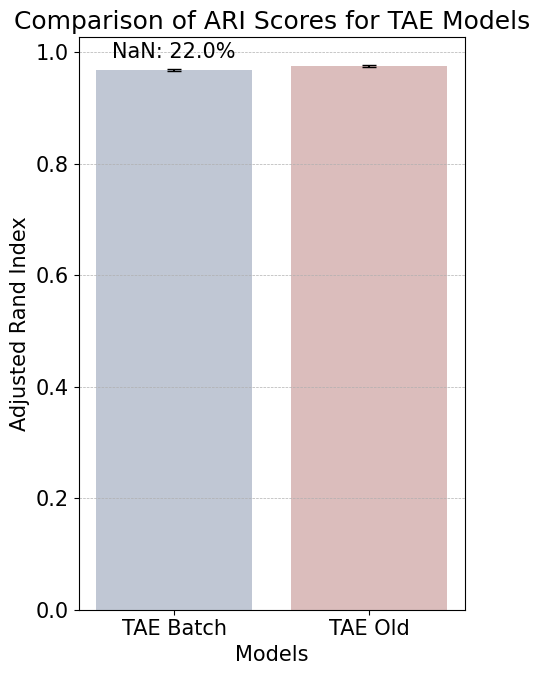

In [19]:
# Convert lists of ARIs into a Pandas DataFrame
data = {
    'ARI Scores': tae_ari_batch[0] + tae_ari_old[0],
    'Models': ['TAE Batch'] * len(tae_ari_batch[0]) + ['TAE Old'] * len(tae_ari_old[0])
}
df = pd.DataFrame(data)

# Calculate the mean and standard error of the mean (SEM) for each model
mean_scores = df.groupby('Models')['ARI Scores'].mean().reset_index()
error_scores = df.groupby('Models')['ARI Scores'].sem().reset_index()  # SEM calculation

# Merge the mean and error data
plot_data = pd.merge(mean_scores, error_scores, on='Models', suffixes=('_mean', '_error'))

# Create the bar plot with error bars
plt.figure(figsize=(5, 7))
ax = sns.barplot(x='Models', y='ARI Scores_mean', data=plot_data, palette="vlag")

# Calculate the positions for each error bar
n_models = len(plot_data['Models'].unique())
offset = 0.2  # Offset can be adjusted based on your visual preference

# Add error bars
for index, row in plot_data.iterrows():
    plt.errorbar(x=index, y=row['ARI Scores_mean'], yerr=row['ARI Scores_error'], fmt='none', c='black', capsize=5)
nan_count_batch = reps - len(tae_ari_batch[0])
batch_bar_position = plot_data.index[plot_data['Models'] == 'TAE Batch'].tolist()[0]
plt.text(batch_bar_position, mean_scores[mean_scores['Models'] == 'TAE Batch']['ARI Scores'].iloc[0] + error_scores[error_scores['Models'] == 'TAE Batch']['ARI Scores'].iloc[0] + 0.02,
         f'NaN: {nan_count_batch*100/50}%', ha='center', color='black')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.title('Comparison of ARI Scores for TAE Models')
plt.ylabel('Adjusted Rand Index')
plt.tight_layout()
plt.show()


### 3.8 Comparative results of all models on the 4 real datasets.

In [20]:
kmeans_ari=[]
ae_ari=[]
tae_ari=[]
kmeans_TAE_embed=[]
stae_ari=[]
kmeans_STAE_embed=[]
datasets = [
    # name,     classes,    normalise, subsample, lr,     reg,    epochs, embedding   n
    ('penguin4', [0,1,2],     True,    False,     0.0001, 0.001,  150,    1,          3), 
    ('iris',     [0,1,2],     False,   False,     0.0001, 0.001,  150,    1,          3),
    ('mnist',    [0,1,2,3,4], False,   True,      0.0005,  0.001,  100,    10,         5),
    ('fashion',  [0,1,2], False,   True,      0.0001,  0.0001,  150,    10,         3)
]
reps=50
for (dataset, class_label, normalise, subsample, lr, reg, epochs, embed, n) in datasets:
    fit_emb = []
    fit_X = []
    clust_assign = []
    fit_AE = []
    clust_assign_stae = []
    fit_emb_stae = []
    X,Y = real_data_loader(dataset=dataset, class_labels_list=class_label, normalise_data=normalise, subsample=subsample)
    n_clusters = n
    for i in range(reps):
        k = KMeans(n_clusters=n_clusters, random_state=i,n_init=10).fit(X)
        fit_X.append(adjusted_rand_score(k.labels_, Y))
        
        # AE
        net = Autoencoder(in_feature=X.shape[1],embed=embed)
        ae_l = train_batch_AE(net, X,Y, lr=lr,epochs=epochs)        
        X_embed = net.enc1(X).cpu().detach().numpy()
        ae_kmeans = KMeans(n_clusters=n_clusters, random_state=i,n_init=10).fit(X_embed)
        AE_clust_assign = ae_kmeans.labels_
        ari = adjusted_rand_score(AE_clust_assign, Y)
        fit_AE.append(ari)
        
        em, assign, loss, reconstructions = train_batch_TAE(X.clone(),Y.clone(), reg=reg, embed=embed, epochs=epochs, lr=lr, n_tensors=n_clusters)
        if not math.isnan(loss[-1]):
            mm = [e.detach() for e in em]
            k = KMeans(n_clusters=n_clusters, random_state=i,n_init=10).fit(mm)
            fit_emb.append(adjusted_rand_score(k.labels_, Y))
            clust_assign.append(adjusted_rand_score(assign, Y))

        # STAE
        #self, n_tensors, in_feature, fst_embed, snd_embed, linear=True, CNN=False
        net = SharedOne(n_tensors=n_clusters, in_feature=X.shape[1], fst_embed = embed*n, snd_embed=embed).to(device)
        embeddings, assign, loss, reconstructions = train_batch_STAE(X.clone(),Y.clone(),net, reg=reg, epochs=epochs, lr=lr,n_tensors=n_clusters)
        if not math.isnan(loss[-1]):
            mm = [e.detach() for e in embeddings]
            k = KMeans(n_clusters=n_clusters, random_state=i,n_init=10).fit(mm)
            fit_emb_stae.append(adjusted_rand_score(k.labels_, Y))
            clust_assign_stae.append(adjusted_rand_score(assign, Y))
    print(dataset)
    print("         kmeans avg: ", np.mean(fit_X))
    print("kmeans AE embed avg: ", np.mean(fit_AE))
    print("   clust assign avg: ", np.mean(clust_assign))
    print("kmeans tae embed avg: ", np.mean(fit_emb))
    print("stae clust assign avg: ", np.mean(clust_assign_stae))
    print("kmeans stae embed avg: ", np.mean(fit_emb_stae))
    print("number of times loss was NaN TAE: ",reps-len(clust_assign))
    print("number of times loss was NaN STAE: ",reps-len(clust_assign_stae))
    kmeans_ari.append(fit_X)
    ae_ari.append(fit_AE)
    tae_ari.append(clust_assign)
    kmeans_TAE_embed.append(fit_emb)
    stae_ari.append(clust_assign_stae)
    kmeans_STAE_embed.append(fit_emb_stae)

penguin4
         kmeans avg:  0.7200039434865811
kmeans AE embed avg:  0.41250310373709376
   clust assign avg:  0.6715389581556225
kmeans tae embed avg:  0.6218234886405493
stae clust assign avg:  0.7549523637942072
kmeans stae embed avg:  0.6688221169977888
number of times loss was NaN TAE:  2
number of times loss was NaN STAE:  0
iris
         kmeans avg:  0.7302382722834697
kmeans AE embed avg:  0.5210792193175058
   clust assign avg:  0.6920853707358525
kmeans tae embed avg:  0.6127804592716014
stae clust assign avg:  0.724599438893597
kmeans stae embed avg:  0.6245185024689657
number of times loss was NaN TAE:  0
number of times loss was NaN STAE:  0
MNIST loaded dataset Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Number of total samples  torch.Size([250])


/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_full[x_idx], dtype=torch.float)
/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y_full[x_idx])


mnist
         kmeans avg:  0.6548554835831044
kmeans AE embed avg:  0.13430836996457676
   clust assign avg:  0.5876598102095552
kmeans tae embed avg:  0.2653546237523993
stae clust assign avg:  0.7040782625344901
kmeans stae embed avg:  0.5569681626773254
number of times loss was NaN TAE:  2
number of times loss was NaN STAE:  0
Fashion MNIST loaded dataset Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Number of total samples  torch.Size([150])


/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_full[x_idx], dtype=torch.float)
/Users/omardebouni/Desktop/tflow/tensorized_autoencoder/new/data.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y_full[x_idx])


fashion
         kmeans avg:  0.44890837195701105
kmeans AE embed avg:  0.1863315155379279
   clust assign avg:  0.5973929148436786
kmeans tae embed avg:  0.5848465047492116
stae clust assign avg:  0.6143930332993262
kmeans stae embed avg:  0.6006316661401917
number of times loss was NaN TAE:  0
number of times loss was NaN STAE:  0


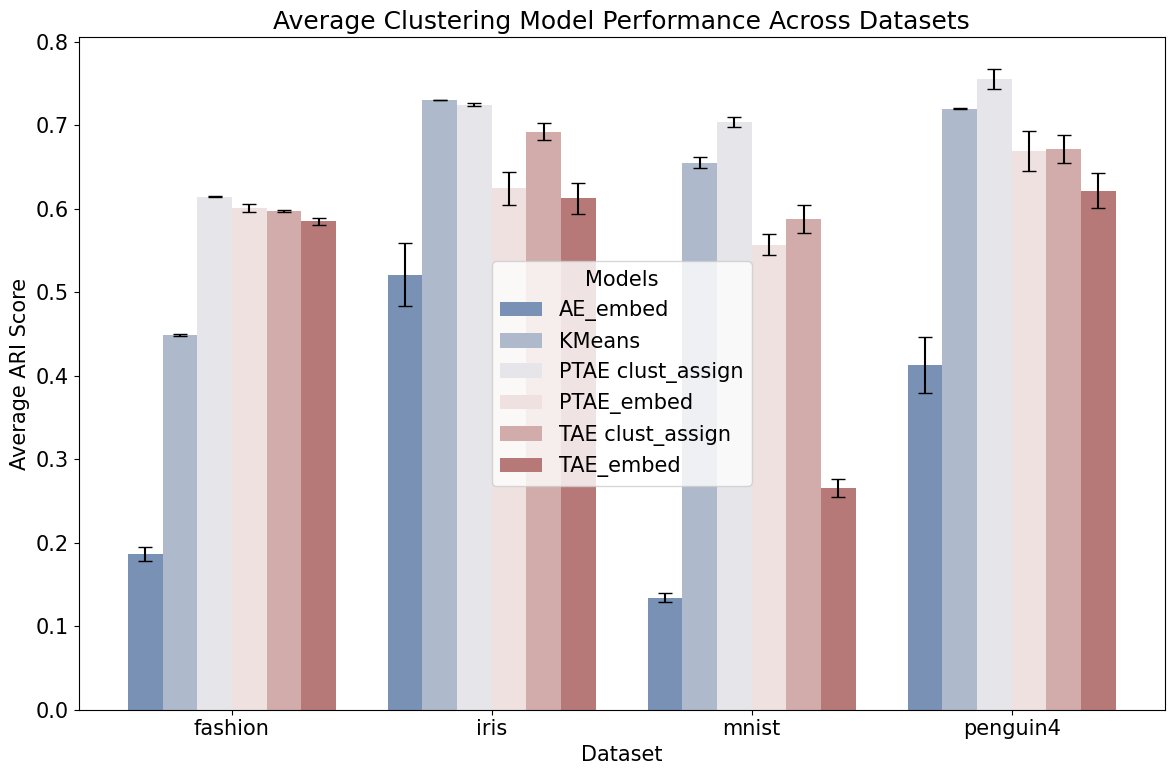

In [21]:
# Names of datasets
datasets = ['penguin4', 'iris', 'mnist', 'fashion']
all_scores = []
all_models = []
all_datasets = []
for i, dataset_name in enumerate(datasets):
    for score_list, model_name in zip([kmeans_ari, ae_ari, tae_ari, kmeans_TAE_embed,stae_ari,kmeans_STAE_embed], ['KMeans', 'AE_embed', 'TAE clust_assign', 'TAE_embed', 'PTAE clust_assign', 'PTAE_embed']):
        all_scores.extend(score_list[i])
        all_models.extend([model_name] * len(score_list[i]))
        all_datasets.extend([dataset_name] * len(score_list[i]))

# Create a DataFrame for easier plotting with Seaborn
data = pd.DataFrame({'ARI Scores': all_scores, 'Models': all_models, 'Dataset': all_datasets})

mean_scores = data.groupby(['Models', 'Dataset'])['ARI Scores'].mean().reset_index()
error_scores = data.groupby(['Models', 'Dataset'])['ARI Scores'].sem().reset_index()  # sem() for standard error, std() for standard deviation

# Merge the mean and error data for plotting
plot_data = pd.merge(mean_scores, error_scores, on=['Models', 'Dataset'], suffixes=('_mean', '_error'))

# Create the bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Dataset', y='ARI Scores_mean', hue='Models', data=plot_data, palette = "vlag")

# Get the total number of bars in a single group
n_bars = len(plot_data['Models'].unique())
# The width of a group of bars
bar_width = 0.8
# Spacing between each group
group_width = n_bars * bar_width
# Individual bar width
single_bar_width = bar_width / n_bars
# Offset from the center of the group
offset = (np.arange(n_bars) - np.arange(n_bars).mean()) * single_bar_width

# Add error bars
for i, dataset in enumerate(plot_data['Dataset'].unique()):
    for j, model in enumerate(plot_data['Models'].unique()):
        subset = plot_data[(plot_data['Models'] == model) & (plot_data['Dataset'] == dataset)]
        # Calculate the position for each bar/errorbar
        # Note: +0.2 is added to align with the seaborn default, adjust this if necessary
        position = i - 0.2 + offset[j]+0.2
        plt.errorbar(x=position, y=subset['ARI Scores_mean'], yerr=subset['ARI Scores_error'], fmt='none', c='black', capsize=5)

plt.title('Average Clustering Model Performance Across Datasets')
plt.ylabel('Average ARI Score')
plt.xlabel('Dataset')
plt.legend(title='Models')
plt.tight_layout()
plt.show()


### 3.9: Denoising on toy datasets

In [22]:
reps = 50 
ae_loss=[]
tae_loss=[]
stae_loss=[]
criterion = nn.MSELoss()
for (data_generation,lr,reg,epochs) in [(parallel_line(noise=0.1), 0.01, 0.01,220), #reg=0.01: 9-14NaN, 0.78
                                   (orthogonal(noise=0.1), 0.01, 0.01, 60), #reg=0.01        : 9-14NaN 0.9
                                   (triangle(noise=0.1),0.005, 0.007, 120), #reg=0.01          : 14-18NaN 0.8
                                   (lines_3D(noise=0.1),0.003, 0.005, 100)]: #reg=0.001         : 28-34NaN 0.6
    ae_mse = []
    tae_mse = []
    stae_mse = []
    X,Y,X_noise,n_clusters = data_generation
    for i in range(reps):
        # AE
        net = Autoencoder(in_feature=X.shape[1],embed=1)
        ae_l = train_batch_AE(net, X_noise,Y, lr=0.01,epochs=epochs,X_out=X)        
        ae_mse.append(ae_l[-1].detach())
        
        embeddings, assign, loss, reconstructions = train_batch_TAE(X_noise.clone(),Y.clone(), reg=reg, embed=1, epochs=epochs, lr=lr,n_tensors=n_clusters, X_out=X.clone())
        if not math.isnan(loss[-1]):
            tae_mse.append(criterion(reconstructions, X).detach())

        # STAE
        #self, n_tensors, in_feature, fst_embed, snd_embed, linear=True, CNN=False
        net = SharedOne(n_tensors=n_clusters, in_feature=X.shape[1], fst_embed = 2, snd_embed=1).to(device)
        embeddings, assign, loss, reconstructions = train_batch_STAE(X_noise.clone(),Y.clone(),net, reg=reg, epochs=epochs, lr=lr,n_tensors=n_clusters, X_out=X.clone())
        if not math.isnan(loss[-1]):
            stae_mse.append(criterion(reconstructions, X).detach())

    print("NEW DATA")
    print(" AE reconstruction error: ", np.mean(ae_mse))
    print("TAE reconstruction error: ", np.mean(tae_mse))
    print("SAE reconstruction error: ", np.mean(stae_mse))
    print("number of times loss was NaN TAE: ",reps-len(tae_mse))
    print("number of times loss was NaN STAE: ",reps-len(stae_mse))
    ae_loss.append(ae_mse)
    tae_loss.append(tae_mse)
    stae_loss.append(stae_mse)

NEW DATA
 AE reconstruction error:  1.461066
TAE reconstruction error:  0.84359777
SAE reconstruction error:  0.22278395
number of times loss was NaN TAE:  9
number of times loss was NaN STAE:  5
NEW DATA
 AE reconstruction error:  4.8069553
TAE reconstruction error:  1.8377178
SAE reconstruction error:  1.6044558
number of times loss was NaN TAE:  13
number of times loss was NaN STAE:  4
NEW DATA
 AE reconstruction error:  4.299673
TAE reconstruction error:  1.3659325
SAE reconstruction error:  1.112763
number of times loss was NaN TAE:  10
number of times loss was NaN STAE:  1
NEW DATA
 AE reconstruction error:  0.9040879
TAE reconstruction error:  0.42652318
SAE reconstruction error:  0.41148958
number of times loss was NaN TAE:  14
number of times loss was NaN STAE:  5


/var/folders/sk/9lczs5_52kq25vck6g54sfv40000gn/T/ipykernel_17896/1798300106.py:25: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(x='Dataset', y='ARI Scores_mean', hue='Models', data=plot_data, palette = n_palette)


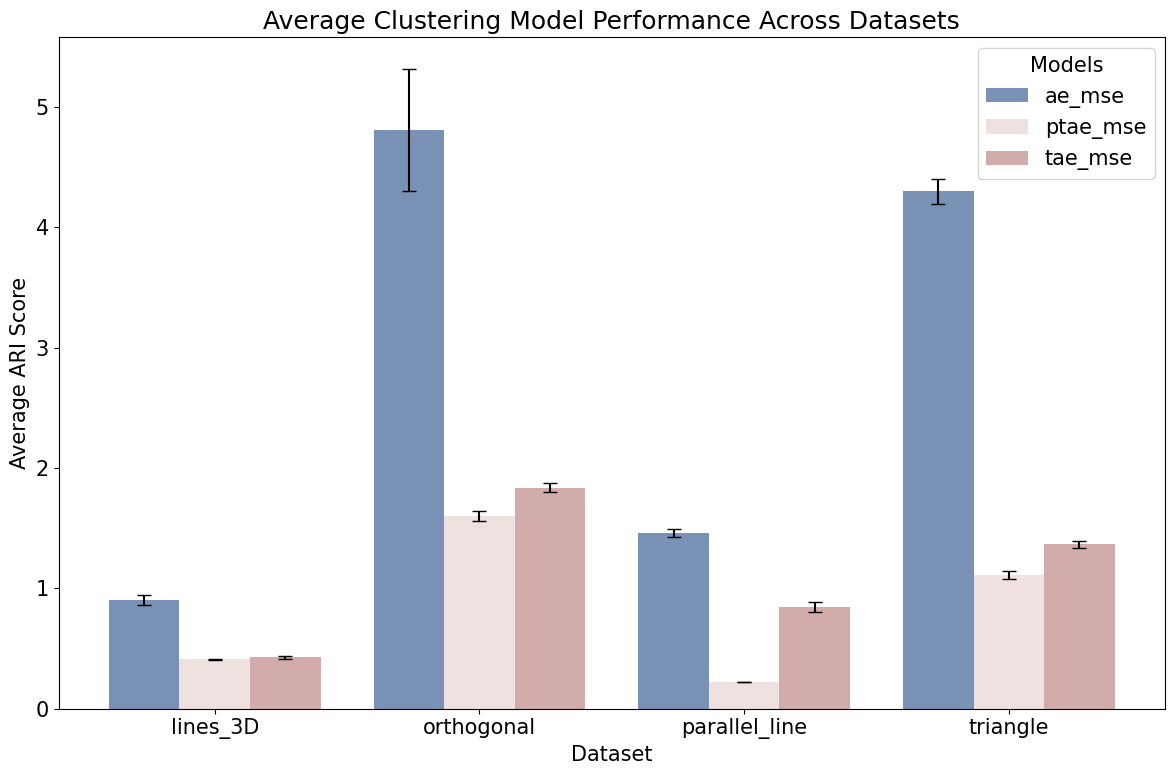

In [23]:
# Example dataset labels
datasets = ['parallel_line', 'orthogonal', 'triangle', 'lines_3D']
# Flatten the ARI lists and create corresponding label lists for plotting
# Make sure ae_ari, tae_ari, kmeans_ari, shared_ari are lists of lists, where each sublist corresponds to a different dataset
all_scores = []
all_models = []
all_datasets = []
for i, dataset_name in enumerate(datasets):
    for score_list, model_name in zip([ae_loss, tae_loss, stae_loss], ['ae_mse', 'tae_mse', 'ptae_mse']):
        all_scores.extend(score_list[i])
        all_models.extend([model_name] * len(score_list[i]))
        all_datasets.extend([dataset_name] * len(score_list[i]))

# Create a DataFrame for easier plotting with Seaborn
data = pd.DataFrame({'ARI Scores': all_scores, 'Models': all_models, 'Dataset': all_datasets})

mean_scores = data.groupby(['Models', 'Dataset'])['ARI Scores'].mean().reset_index()
error_scores = data.groupby(['Models', 'Dataset'])['ARI Scores'].sem().reset_index()  # sem() for standard error, std() for standard deviation

# Merge the mean and error data for plotting
plot_data = pd.merge(mean_scores, error_scores, on=['Models', 'Dataset'], suffixes=('_mean', '_error'))

# Create the bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Dataset', y='ARI Scores_mean', hue='Models', data=plot_data, palette = n_palette)

# Get the total number of bars in a single group
n_bars = len(plot_data['Models'].unique())
# The width of a group of bars
bar_width = 0.8
# Spacing between each group
group_width = n_bars * bar_width
# Individual bar width
single_bar_width = bar_width / n_bars
# Offset from the center of the group
offset = (np.arange(n_bars) - np.arange(n_bars).mean()) * single_bar_width

# Add error bars
for i, dataset in enumerate(plot_data['Dataset'].unique()):
    for j, model in enumerate(plot_data['Models'].unique()):
        subset = plot_data[(plot_data['Models'] == model) & (plot_data['Dataset'] == dataset)]
        # Calculate the position for each bar/errorbar
        # Note: +0.2 is added to align with the seaborn default, adjust this if necessary
        position = i - 0.2 + offset[j]+0.2
        plt.errorbar(x=position, y=subset['ARI Scores_mean'], yerr=subset['ARI Scores_error'], fmt='none', c='black', capsize=5)

plt.title('Average Clustering Model Performance Across Datasets')
plt.ylabel('Average ARI Score')
plt.xlabel('Dataset')
plt.legend(title='Models')
plt.tight_layout()
plt.show()
